In [1]:
import os

import cv2
import numpy as np
import imutils
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import progressbar

import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

Using TensorFlow backend.


In [2]:
TRAIN_ROOT = 'train'
TEST_ROOT = 'testset'

In [3]:
def get_images_and_labels(root):
    images, labels = [], []
    df = []
    for path, dic, files in os.walk(root):
        for file in files:
            if file.endswith('.jpg'):
                df.append([os.path.join(path, file), path.split('\\')[1]])
                
    return pd.DataFrame(df, columns=['img_path', 'label'])

In [4]:
def get_test_set(root):
    paths = []
    for path, dic, files in os.walk(root):
        for file in files:
            if file.endswith('.jpg'):
                paths.append([os.path.join(path, file)])                
    return pd.DataFrame(paths, columns=['img_path'])

In [5]:
img_df = get_images_and_labels(TRAIN_ROOT)
NUM_CLASSES = len(list(set(img_df.label.values)))
test_df = get_test_set(TEST_ROOT)

** 圖片寬高與比例 **
<br>觀察圖片寬高以及比例的分布，作為前處理的依據

In [6]:
width, height, ratio = [], [], []
pbar = progressbar.ProgressBar(max_value=len(img_df))
pbar.start()

for i, row in img_df.iterrows():
    image = cv2.imread(row.img_path)
    width.append(image.shape[1])
    height.append(image.shape[0])
    ratio.append(image.shape[0] / image.shape[1])
    pbar.update(i)
    
img_df['width'] = width
img_df['height'] = height
img_df['ratio'] = ratio

 97% (2910 of 2985) |################### | Elapsed Time: 0:00:02 ETA:   0:00:00

In [7]:
width, height, ratio = [], [], []
pbar = progressbar.ProgressBar(max_value=len(img_df))
pbar.start()

for i, row in test_df.iterrows():
    image = cv2.imread(row.img_path)
    width.append(image.shape[1])
    height.append(image.shape[0])
    ratio.append(image.shape[0] / image.shape[1])
    pbar.update(i)
    
test_df['width'] = width
test_df['height'] = height
test_df['ratio'] = ratio

 48% (1436 of 2985) |#########           | Elapsed Time: 0:00:01 ETA:   0:00:01

** 寬度 **
<br>寬度的分布大部分落在256pixels

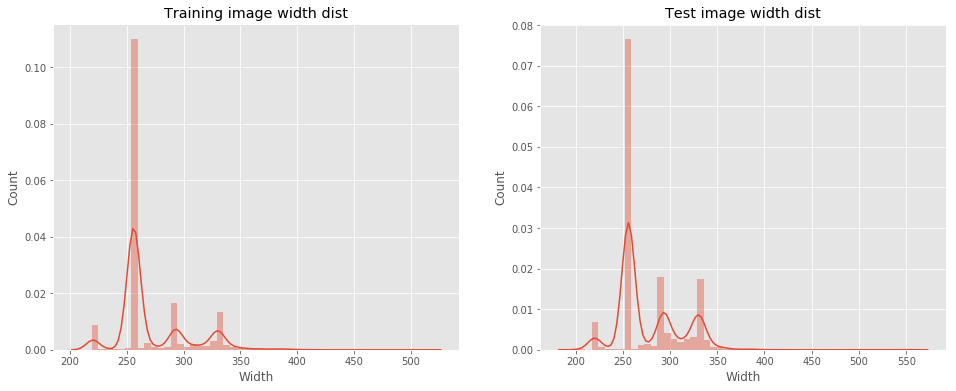

In [8]:
fig=plt.gcf()
fig.set_size_inches(16, 6)
plt.subplot(121)
sns.distplot(img_df.width);
plt.title("Training image width dist")
plt.xlabel("Width")
plt.ylabel("Count")

plt.subplot(122)
sns.distplot(test_df.width);
plt.title("Test image width dist")
plt.xlabel("Width")
plt.ylabel("Count")
plt.show()

** 高度 **
<br>寬度的分布大部分落在256pixels

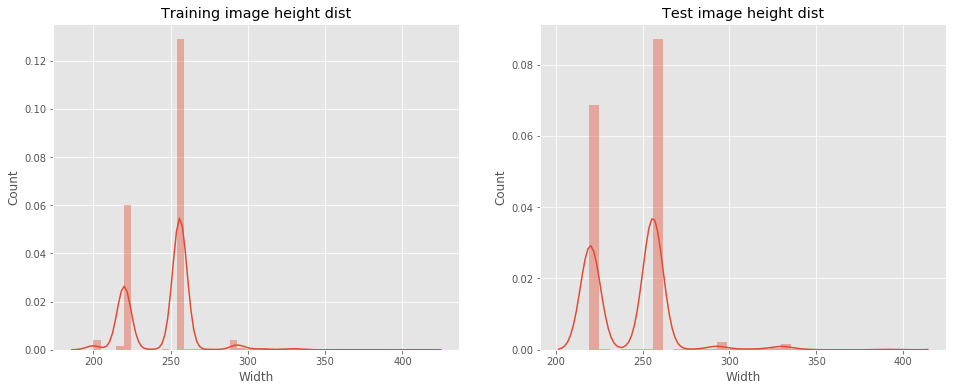

In [9]:
fig=plt.gcf()
fig.set_size_inches(16, 6)
plt.subplot(121)
sns.distplot(img_df.height);
plt.title("Training image height dist")
plt.xlabel("Width")
plt.ylabel("Count")

plt.subplot(122)
sns.distplot(test_df.height);
plt.title("Test image height dist")
plt.xlabel("Width")
plt.ylabel("Count")
plt.show()

** 高寬比例 **
<br>大部分的圖片高寬比例為1:1

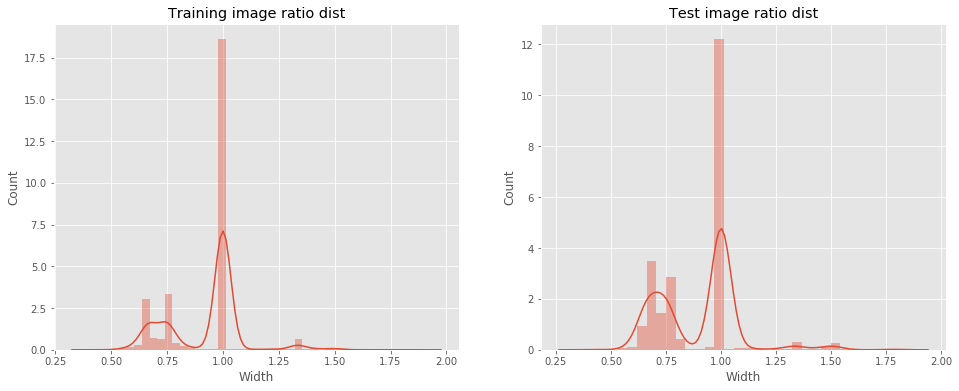

In [10]:
fig=plt.gcf()
fig.set_size_inches(16, 6)
plt.subplot(121)
sns.distplot(img_df.ratio);
plt.title("Training image ratio dist")
plt.xlabel("Width")
plt.ylabel("Count")

plt.subplot(122)
sns.distplot(test_df.ratio);
plt.title("Test image ratio dist")
plt.xlabel("Width")
plt.ylabel("Count")
plt.show()

## 2.Feature engineering
<li>透過預處理將比例非對等的圖片處理成1:1的尺寸</li>
<li>label one hot encoding</li>

### 2.1
** 圖片處理策略 **
>所有的圖片在寬、高、比例上均有集中的趨勢，將圖片處理為256*256的1:1圖片是以下選用的作法，若比例原本是1:1的圖片可以直接resize，而寬高比例非1:1的圖片將切去過多的部分

#### 2.1.1 切除
將郭於的部分切除，符合寬高1:1

In [11]:
class AspectAwarePreprocessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        # store the target image width, height, and interpolation
        # method used when resizing
        self.width = width
        self.height = height
        self.inter = inter

    def preprocess(self, image):
        # grab the dimensions of the image and then initialize
        # the deltas to use when cropping
        (h, w) = image.shape[:2]
        dW = 0
        dH = 0

        # if the width is smaller than the height, then resize
        # along the width (i.e., the smaller dimension) and then
        # update the deltas to crop the height to the desired
        # dimension
        if w < h:
            image = imutils.resize(image, width=self.width,
                inter=self.inter)
            dH = int((image.shape[0] - self.height) / 2.0)

        # otherwise, the height is smaller than the width so
        # resize along the height and then update the deltas
        # crop along the width
        else:
            image = imutils.resize(image, height=self.height,
                inter=self.inter)
            dW = int((image.shape[1] - self.width) / 2.0)

        # now that our images have been resized, we need to
        # re-grab the width and height, followed by performing
        # the crop
        (h, w) = image.shape[:2]
        image = image[dH:h - dH, dW:w - dW]

        # finally, resize the image to the provided spatial
        # dimensions to ensure our output image is always a fixed
        # size
        return cv2.resize(image, (self.width, self.height),
            interpolation=self.inter)

In [12]:
#定義畫面切除之preprocessor
preprocessor = AspectAwarePreprocessor(256, 256)

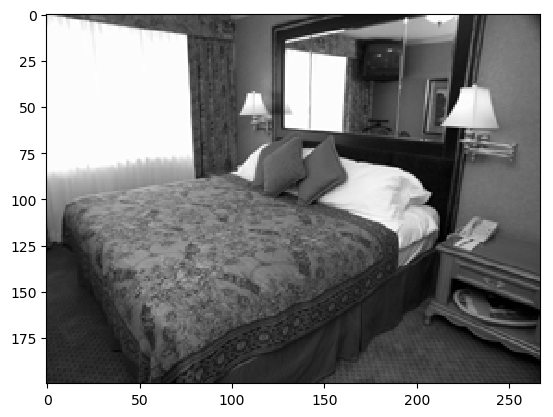

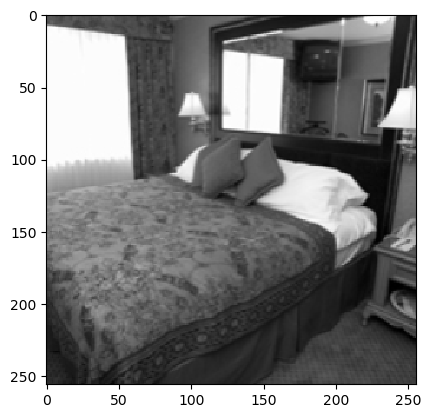

In [13]:
plt.style.use('default')
#將過高的圖片切割成1:1的尺寸
img = cv2.imread(img_df.iloc[0].img_path)
plt.imshow(img, cmap='gray')
plt.show()
plt.imshow(preprocessor.preprocess(img), cmap='gray')
plt.show()

** feature set one **

In [14]:
ft_set_1 = [preprocessor.preprocess(cv2.imread(row.img_path)) for _, row in img_df.iterrows()]
ft_set_1 = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in ft_set_1]
ft_set_1 = np.array(ft_set_1).astype('float')
ft_set_1_mean = np.mean(ft_set_1, axis=0)
ft_set_1 -= ft_set_1_mean
ft_set_1 = ft_set_1.reshape((len(ft_set_1), 256, 256, 1))
ft_set_1.shape

(2985, 256, 256, 1)

#### 2.1.2 填補
以黑色填補圖片，使整張圖的特徵都得以被保留

In [15]:
def make_square_by_padding(im, desired_size=256):
    old_size = im.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(im, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)

    return new_im

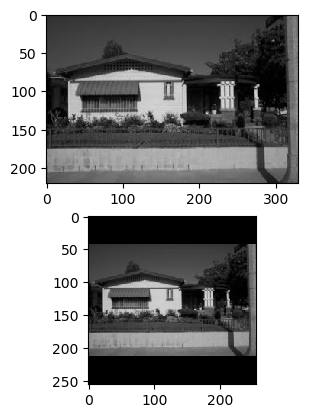

In [16]:
demo_img = cv2.imread('train\CALsuburb\image_0001.jpg')
filled_with_zero = make_square_by_padding(demo_img)

plt.figure(1)
plt.subplot(211)
plt.imshow(demo_img)

plt.subplot(212)
plt.imshow(filled_with_zero)
plt.show()

In [17]:
ft_set_2 = [make_square_by_padding(cv2.imread(row.img_path)) for _, row in img_df.iterrows()]
ft_set_2 = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in ft_set_2]
ft_set_2 = np.array(ft_set_2).astype('float')
ft_set_2_mean = np.mean(ft_set_2, axis=0)
ft_set_2 -= ft_set_2_mean
ft_set_2 = ft_set_2.reshape((len(ft_set_1), 256, 256, 1))
ft_set_2.shape

(2985, 256, 256, 1)

### 2.2 One hot label

In [18]:
class_mapping = {
'CALsuburb': 9,
'PARoffice': 7,
'bedroom': 12,
'coast': 10,
'forest': 4,
'highway': 14,
'industrial': 2,
'insidecity': 3,
'kitchen': 0,
'livingroom': 5,
'mountain': 8,
'opencountry': 6,
'store': 11,
'street': 1,
'tallbuilding': 13}

In [19]:
img_df['int_label'] = img_df['label'].map(class_mapping)
labels_one_hot = to_categorical(img_df['int_label'])

In [20]:
labels_one_hot[:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]],
      dtype=float32)

** 分層採樣 **
<br>分層採樣train/test set，因為類別的數量並不一致，因此分層採樣有助於避免抽樣的偏誤

In [30]:
from sklearn.model_selection import StratifiedShuffleSplit

In [22]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(ft_set_1, img_df.int_label):
    ft_set_1_strat_train_x = np.array([ft_set_1[i] for i in train_index])
    ft_set_1_strat_train_y = np.uint8([labels_one_hot[i] for i in train_index])
    ft_set_1_strat_test_x = np.array([ft_set_1[i] for i in test_index])
    ft_set_1_strat_test_y = np.uint8([labels_one_hot[i] for i in test_index])
    
    ft_set_2_strat_train_x = np.array([ft_set_2[i] for i in train_index])
    ft_set_2_strat_train_y = np.uint8([labels_one_hot[i] for i in train_index])
    ft_set_2_strat_test_x = np.array([ft_set_2[i] for i in test_index])
    ft_set_2_strat_test_y = np.uint8([labels_one_hot[i] for i in test_index])

## 3.Training

** Resnet **
<br>以resnet作為採用的分類模型

In [9]:
from __future__ import division
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Input, Activation, Dense, Flatten
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K
from keras.utils import plot_model
import six



def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3

def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier

def _bn_relu(input):
    """
    Helper to build a BN -> relu block
    """

    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)

def _conv_bn_relu(**conv_params):

    """
    Helper to build a conv -> BN -> relu block
    """

    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,strides=strides, padding=padding,kernel_initializer=kernel_initializer,kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)
    return f

def _bn_relu_conv(**conv_params):

    """
    Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """

    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,strides=strides, padding=padding, kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)(activation)
    return f

def _shortcut(input, residual):

    """
    Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.

    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input

    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS], kernel_size=(1, 1), strides=(stride_width, stride_height), padding="valid", kernel_initializer="he_normal",kernel_regularizer=l2(0.0001))(input)
    return add([shortcut, residual])

def _residual_block(block_function, filters, repetitions, is_first_layer=False):

    """
    Builds a residual block with repeating bottleneck blocks.
    """

    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides, is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input
    return f

def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):

    """
    Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """

    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),strides=init_strides, padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3), strides=init_strides)(input)
        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)
    return f

def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):

    """
    Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """

    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1), strides=init_strides, padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1), strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)
    return f

class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """
        Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """

        _handle_dim_ordering()

        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_dim_ordering() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]), strides=(1, 1))(block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal", activation="softmax")(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model


    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])

### 3.1 Baseline model

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

In [11]:
aug = ImageDataGenerator(
                        rotation_range=10, 
                         width_shift_range=0.1, 
                         height_shift_range=0.1, 
                         shear_range=0.05, 
                         zoom_range=0.05,
                         horizontal_flip=True, 
                         fill_mode="nearest")

In [12]:
def poly_decay(epoch):
    # initialize the maximum number of epochs, base learning rate,
    # and power of the polynomial
    global EPOCHS
    global LR
    global POWER_DECAY
    maxEpochs = EPOCHS
    baseLR = LR
    power = POWER_DECAY

    # compute the new learning rate based on polynomial decay
    alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power

    # return the new learning rate
    return alpha

In [13]:
EPOCHS = 100
BATCH_SIZE = 32
LR = 0.01
POWER_DECAY = 1.0

** Feature set one **
<br>切割圖片作為處理的特徵

In [30]:
resnet_101=ResnetBuilder.build_resnet_101((1, 256, 256), 15)
resnet_101.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

ft_1_training_history = resnet_101.fit_generator(aug.flow(ft_set_1_strat_train_x, ft_set_1_strat_train_y, batch_size=BATCH_SIZE),
                         validation_data=(ft_set_1_strat_test_x, ft_set_1_strat_test_y), 
                         steps_per_epoch=len(ft_set_1_strat_train_x) // BATCH_SIZE,
                         epochs=EPOCHS, 
                         callbacks=[LearningRateScheduler(poly_decay)], 
                         verbose=1)

Epoch 1/100
74/74 [==============================] - 60s 813ms/step - loss: 10.2834 - acc: 0.1421 - val_loss: 17.5825 - val_acc: 0.0938
Epoch 2/100
74/74 [==============================] - 32s 434ms/step - loss: 5.1197 - acc: 0.1926 - val_loss: 4.9129 - val_acc: 0.1156
Epoch 3/100
74/74 [==============================] - 32s 436ms/step - loss: 3.6535 - acc: 0.2517 - val_loss: 4.2167 - val_acc: 0.1575
Epoch 4/100
74/74 [==============================] - 32s 433ms/step - loss: 3.0276 - acc: 0.3139 - val_loss: 3.7971 - val_acc: 0.2060
Epoch 5/100
74/74 [==============================] - 33s 444ms/step - loss: 2.7063 - acc: 0.3371 - val_loss: 3.9237 - val_acc: 0.1993
Epoch 6/100
74/74 [==============================] - 32s 439ms/step - loss: 2.4662 - acc: 0.3659 - val_loss: 3.8784 - val_acc: 0.1926
Epoch 7/100
74/74 [==============================] - 33s 440ms/step - loss: 2.2204 - acc: 0.4255 - val_loss: 2.8530 - val_acc: 0.2797
Epoch 8/100
74/74 [==============================] - 32s 434

Epoch 62/100
74/74 [==============================] - 33s 447ms/step - loss: 1.0495 - acc: 0.7029 - val_loss: 1.7791 - val_acc: 0.5260
Epoch 63/100
74/74 [==============================] - 33s 441ms/step - loss: 1.0236 - acc: 0.7079 - val_loss: 1.3719 - val_acc: 0.6047
Epoch 64/100
74/74 [==============================] - 32s 432ms/step - loss: 0.9913 - acc: 0.7097 - val_loss: 1.8681 - val_acc: 0.5327
Epoch 65/100
74/74 [==============================] - 32s 435ms/step - loss: 1.0114 - acc: 0.7192 - val_loss: 1.4890 - val_acc: 0.5863
Epoch 66/100
74/74 [==============================] - 32s 434ms/step - loss: 0.9931 - acc: 0.7106 - val_loss: 1.3229 - val_acc: 0.5896
Epoch 67/100
74/74 [==============================] - 32s 431ms/step - loss: 0.9729 - acc: 0.7232 - val_loss: 1.0818 - val_acc: 0.6667
Epoch 68/100
74/74 [==============================] - 32s 435ms/step - loss: 0.9942 - acc: 0.7057 - val_loss: 1.3016 - val_acc: 0.5863
Epoch 69/100
74/74 [==============================] - 3

** Feature set two **
<br>填補圖片作為處理的特徵

In [31]:
resnet_101_b=ResnetBuilder.build_resnet_101((1, 256, 256), 15)
resnet_101_b.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

ft_2_training_history = resnet_101_b.fit_generator(aug.flow(ft_set_2_strat_train_x, ft_set_2_strat_train_y, batch_size=BATCH_SIZE),
                                 validation_data=(ft_set_2_strat_test_x, ft_set_2_strat_test_y), 
                                 steps_per_epoch=len(ft_set_2_strat_train_x) // BATCH_SIZE,
                                 epochs=EPOCHS, 
                                 callbacks=[LearningRateScheduler(poly_decay)], 
                                 verbose=1)

Epoch 1/100
74/74 [==============================] - 61s 827ms/step - loss: 9.5904 - acc: 0.2026 - val_loss: 4.9508 - val_acc: 0.2580
Epoch 2/100
74/74 [==============================] - 33s 452ms/step - loss: 3.7675 - acc: 0.2857 - val_loss: 3.4286 - val_acc: 0.2446
Epoch 3/100
74/74 [==============================] - 33s 451ms/step - loss: 2.8928 - acc: 0.3108 - val_loss: 3.5387 - val_acc: 0.1575
Epoch 4/100
74/74 [==============================] - 34s 453ms/step - loss: 2.4582 - acc: 0.3588 - val_loss: 3.2579 - val_acc: 0.1575
Epoch 5/100
74/74 [==============================] - 34s 453ms/step - loss: 2.2273 - acc: 0.4027 - val_loss: 3.3241 - val_acc: 0.2680
Epoch 6/100
74/74 [==============================] - 33s 450ms/step - loss: 1.9973 - acc: 0.4547 - val_loss: 2.4198 - val_acc: 0.2948
Epoch 7/100
74/74 [==============================] - 33s 451ms/step - loss: 1.8347 - acc: 0.4935 - val_loss: 5.6234 - val_acc: 0.1893
Epoch 8/100
74/74 [==============================] - 33s 448ms

Epoch 62/100
74/74 [==============================] - 33s 441ms/step - loss: 0.8871 - acc: 0.7454 - val_loss: 1.3132 - val_acc: 0.5980
Epoch 63/100
74/74 [==============================] - 33s 441ms/step - loss: 0.9174 - acc: 0.7415 - val_loss: 1.2244 - val_acc: 0.6382
Epoch 64/100
74/74 [==============================] - 32s 439ms/step - loss: 0.9154 - acc: 0.7374 - val_loss: 1.0430 - val_acc: 0.6767
Epoch 65/100
74/74 [==============================] - 33s 447ms/step - loss: 0.8850 - acc: 0.7391 - val_loss: 1.3530 - val_acc: 0.6198
Epoch 66/100
74/74 [==============================] - 32s 439ms/step - loss: 0.8506 - acc: 0.7567 - val_loss: 1.5925 - val_acc: 0.5293
Epoch 67/100
74/74 [==============================] - 33s 440ms/step - loss: 0.8453 - acc: 0.7524 - val_loss: 1.2955 - val_acc: 0.6064
Epoch 68/100
74/74 [==============================] - 32s 437ms/step - loss: 0.8502 - acc: 0.7627 - val_loss: 1.1474 - val_acc: 0.6817
Epoch 69/100
74/74 [==============================] - 3

### Baseline模型預測上繳 

** 填補方法做為特徵工程的繳交 **

In [32]:
test_set = [make_square_by_padding(cv2.imread(row.img_path)) for _, row in test_df.iterrows()]
test_set = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in test_set]
test_set = np.array(test_set).astype('float')
test_set_mean = np.mean(test_set, axis=0)
test_set -= test_set_mean
test_set = test_set.reshape((len(test_set), 256, 256, 1))
test_set.shape

(1500, 256, 256, 1)

In [34]:
submission = pd.DataFrame()
submission['id'] = test_df.img_path.apply(lambda _path:_path.split('\\')[1].split('.')[0])
y_pred = resnet_101_b.predict(test_set)
y_pred = [np.argmax(row) for row in y_pred]
submission['class'] = y_pred
submission.to_csv('submissions/submission_v1.csv', index=False)

<img src='images/feature_set_2_submission.jpg'>

** 削除方法做為特徵工程的繳交 **

In [47]:
test_set = [preprocessor.preprocess(cv2.imread(row.img_path)) for _, row in test_df.iterrows()]
test_set = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in test_set]
test_set = np.array(test_set).astype('float')
test_set_mean = np.mean(test_set, axis=0)
test_set -= test_set_mean
test_set = test_set.reshape((len(test_set), 256, 256, 1))
test_set.shape

(1500, 256, 256, 1)

In [49]:
submission = pd.DataFrame()
submission['id'] = test_df.img_path.apply(lambda _path:_path.split('\\')[1].split('.')[0])
y_pred = resnet_101.predict(test_set)
y_pred = [np.argmax(row) for row in y_pred]
submission['class'] = y_pred
submission.to_csv('submissions/submission_v2.csv', index=False)

<img src='images/feature_set_1_submission.jpg'>

### 3.1 Summary
使用填補方法作為特徵的模型在繳交成績上好上許多，因此便保留填補方法而刪去削除的方式

## 3.2 Analysis

** 比較不同模型訓練過程之準確度變化 **

In [63]:
def compare_training_accuracy(train_history_one, train_history_two):
    fig=plt.gcf()
    fig.set_size_inches(16, 6)
    plt.subplot(121)
    plt.plot(train_history_one.history["acc"])
    plt.plot(train_history_one.history["val_acc"])
    plt.title("Training accuracy history for model trained on feature set one")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["train", "validation"], loc="upper left")
    
    plt.subplot(122)
    plt.plot(train_history_two.history["acc"])
    plt.plot(train_history_two.history["val_acc"])
    plt.title("Training accuracy history for model trained on feature set two")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

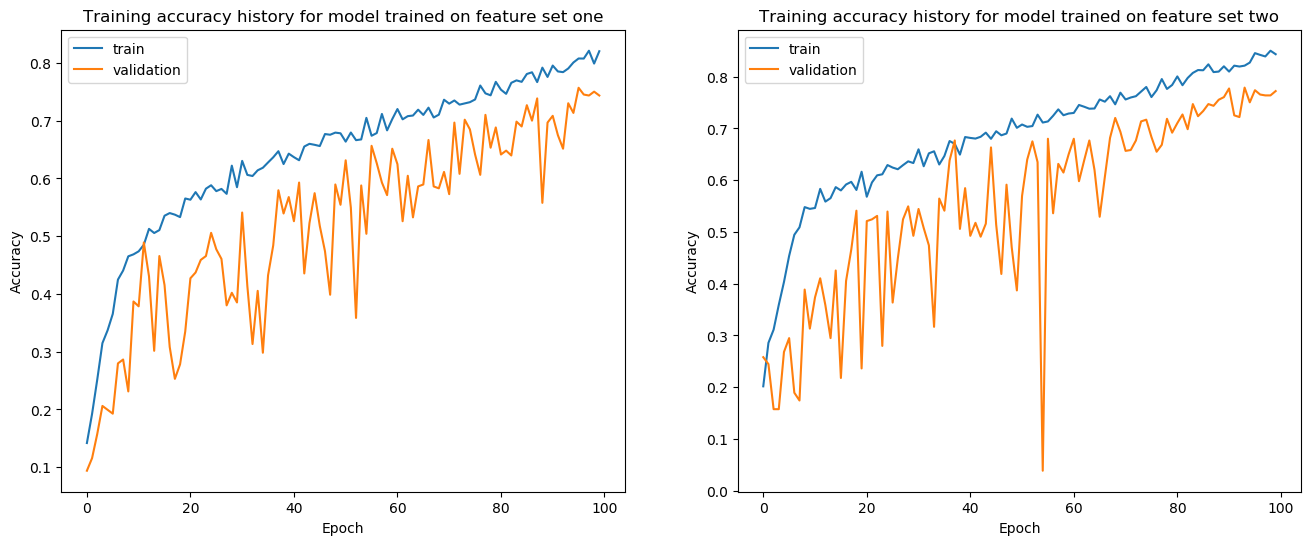

In [64]:
compare_training_accuracy(ft_1_training_history, ft_2_training_history)

** 比較不同模型訓練過程之損失函數變化 **

In [61]:
def compare_training_loss(train_history_one, train_history_two):
    fig=plt.gcf()
    fig.set_size_inches(16, 6)
    plt.subplot(121)
    plt.plot(train_history_one.history["loss"])
    plt.plot(train_history_one.history["val_loss"])
    plt.title("Training loss history for model trained on feature set one")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train", "validation"], loc="upper left")
    
    plt.subplot(122)
    plt.plot(train_history_two.history["loss"])
    plt.plot(train_history_two.history["val_loss"])
    plt.title("Training loss history for model trained on feature set two")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

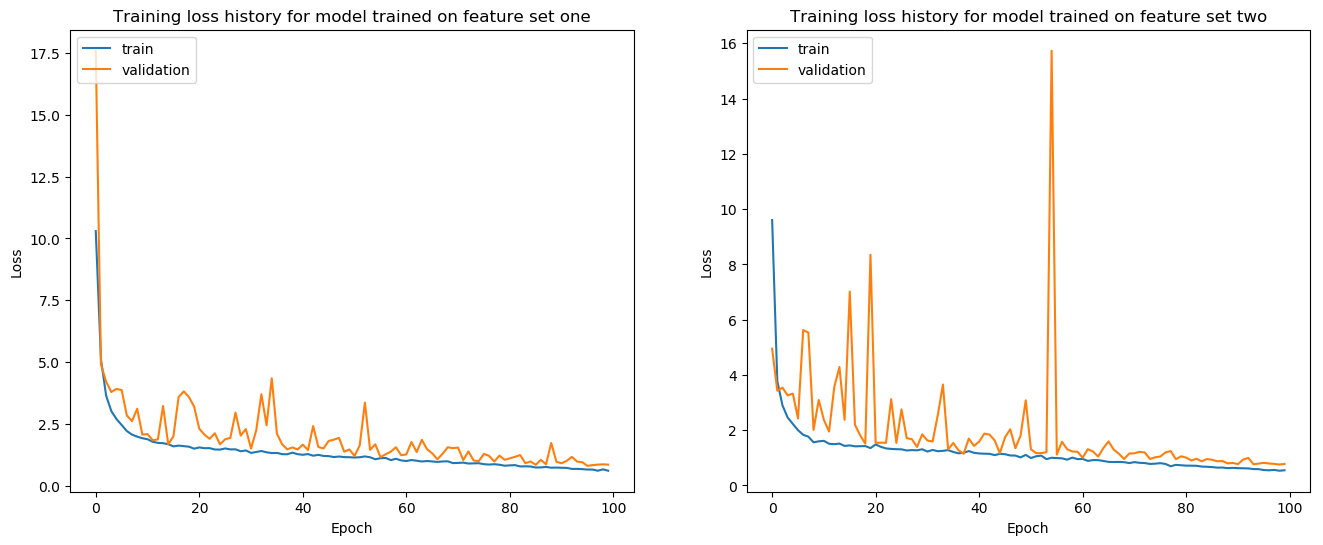

In [62]:
compare_training_loss(ft_1_training_history, ft_2_training_history)

** comfusion matrix之比較 **

In [39]:
from sklearn.metrics import confusion_matrix, accuracy_score

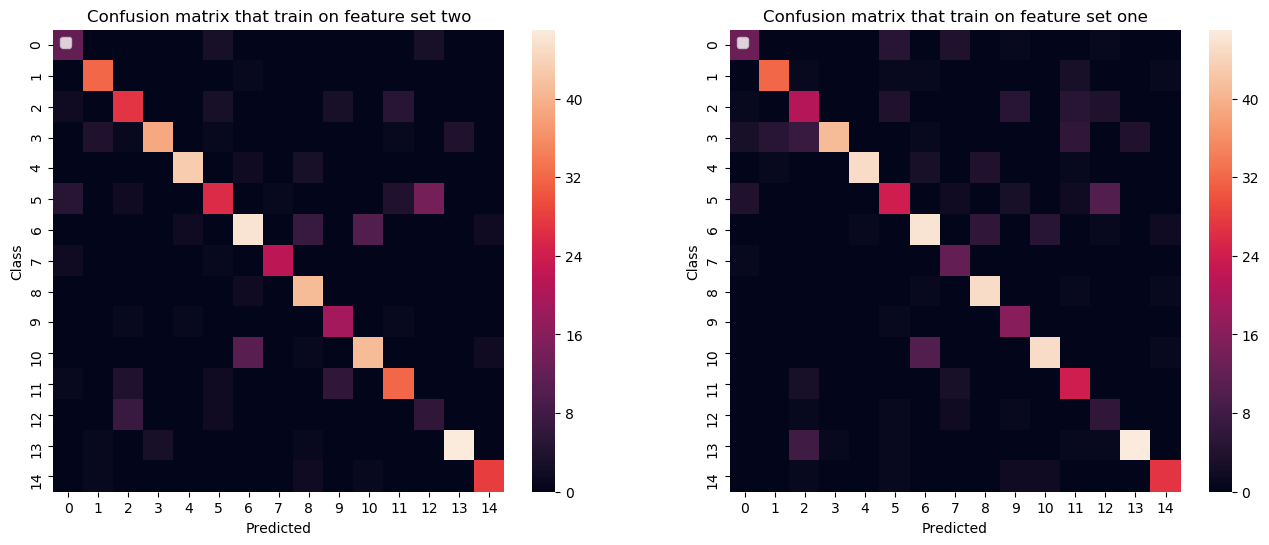

In [60]:
fig=plt.gcf()
fig.set_size_inches(16, 6)
#Confusion matrix for model trained on feature set one
plt.subplot(121)
y_pred = resnet_101_b.predict(ft_set_2_strat_test_x)
y_pred = [np.argmax(row) for row in y_pred]
truth = [np.argmax(row) for row in ft_set_2_strat_test_y]
sns.heatmap(confusion_matrix(y_pred, truth))
plt.title("Confusion matrix that train on feature set two")
plt.xlabel("Predicted")
plt.ylabel("Class")
plt.legend(["train", "validation"], loc="upper left")
#Confusion matrix for model trained on feature set two
plt.subplot(122)
y_pred = resnet_101.predict(ft_set_1_strat_test_x)
y_pred = [np.argmax(row) for row in y_pred]
truth = [np.argmax(row) for row in ft_set_1_strat_test_y]
sns.heatmap(confusion_matrix(y_pred, truth))
plt.title("Confusion matrix that train on feature set one")
plt.xlabel("Predicted")
plt.ylabel("Class")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

** error分析 **
<li>繳交的評比低於訓練分數6%，足見有overfitting的情形。這可能是前處理程序當中train、test set是分開處理造成的(因減去不同的"mean")，改善作法是將兩資料集的圖片做同時預處理。</li>

In [26]:
dataset = pd.concat((img_df, test_df))

ft_set_2 = [make_square_by_padding(cv2.imread(row.img_path)) for _, row in dataset.iterrows()]
ft_set_2 = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in ft_set_2]
ft_set_2 = np.array(ft_set_2).astype('float')
ft_set_2_mean = np.mean(ft_set_2, axis=0)
ft_set_2 -= ft_set_2_mean
ft_set_2 = ft_set_2.reshape((len(ft_set_2), 256, 256, 1))
ft_set_2.shape

C:\Users\User\AppData\Local\conda\conda\envs\ds\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(4485, 256, 256, 1)

In [32]:
train_x = ft_set_2[:len(img_df),:,:,:]
train_y = dataset.iloc[:len(img_df)].int_label
train_y = to_categorical(train_y)
test_x = ft_set_2[len(img_df):,:,:,:]

In [33]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(train_x, img_df.int_label):
    ft_set_2_strat_train_x = np.array([train_x[i] for i in train_index])
    ft_set_2_strat_train_y = np.uint8([train_y[i] for i in train_index])
    ft_set_2_strat_test_x = np.array([train_x[i] for i in test_index])
    ft_set_2_strat_test_y = np.uint8([train_y[i] for i in test_index])

In [34]:
resnet_101_b=ResnetBuilder.build_resnet_101((1, 256, 256), 15)
resnet_101_b.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

ft_2_training_history = resnet_101_b.fit_generator(aug.flow(ft_set_2_strat_train_x, ft_set_2_strat_train_y, batch_size=BATCH_SIZE),
                                 validation_data=(ft_set_2_strat_test_x, ft_set_2_strat_test_y), 
                                 steps_per_epoch=len(ft_set_2_strat_train_x) // BATCH_SIZE,
                                 epochs=EPOCHS, 
                                 callbacks=[LearningRateScheduler(poly_decay)], 
                                 verbose=1)

Epoch 1/100
74/74 [==============================] - 59s 799ms/step - loss: 11.4698 - acc: 0.1555 - val_loss: 9.2968 - val_acc: 0.0955
Epoch 2/100
74/74 [==============================] - 32s 434ms/step - loss: 4.9271 - acc: 0.2781 - val_loss: 4.3394 - val_acc: 0.1843
Epoch 3/100
74/74 [==============================] - 32s 434ms/step - loss: 3.2518 - acc: 0.3165 - val_loss: 3.1397 - val_acc: 0.2312
Epoch 4/100
74/74 [==============================] - 32s 434ms/step - loss: 2.6012 - acc: 0.3544 - val_loss: 2.5218 - val_acc: 0.3384
Epoch 5/100
74/74 [==============================] - 32s 433ms/step - loss: 2.2550 - acc: 0.4249 - val_loss: 3.3861 - val_acc: 0.2278
Epoch 6/100
74/74 [==============================] - 32s 434ms/step - loss: 2.1226 - acc: 0.4515 - val_loss: 2.3345 - val_acc: 0.3317
Epoch 7/100
74/74 [==============================] - 32s 434ms/step - loss: 1.9169 - acc: 0.4902 - val_loss: 2.1246 - val_acc: 0.3350
Epoch 8/100
74/74 [==============================] - 32s 434m

Epoch 62/100
74/74 [==============================] - 32s 436ms/step - loss: 0.9292 - acc: 0.7183 - val_loss: 1.6281 - val_acc: 0.5059
Epoch 63/100
74/74 [==============================] - 32s 435ms/step - loss: 0.9423 - acc: 0.7383 - val_loss: 0.9692 - val_acc: 0.7203
Epoch 64/100
74/74 [==============================] - 32s 435ms/step - loss: 0.9121 - acc: 0.7456 - val_loss: 0.9757 - val_acc: 0.7353
Epoch 65/100
74/74 [==============================] - 32s 434ms/step - loss: 0.9188 - acc: 0.7305 - val_loss: 2.0807 - val_acc: 0.4556
Epoch 66/100
74/74 [==============================] - 32s 435ms/step - loss: 0.9104 - acc: 0.7440 - val_loss: 1.0964 - val_acc: 0.6734
Epoch 67/100
74/74 [==============================] - 32s 436ms/step - loss: 0.8936 - acc: 0.7547 - val_loss: 1.0675 - val_acc: 0.6566
Epoch 68/100
74/74 [==============================] - 32s 435ms/step - loss: 0.8578 - acc: 0.7569 - val_loss: 1.1966 - val_acc: 0.6214
Epoch 69/100
74/74 [==============================] - 3

In [36]:
submission = pd.DataFrame()
submission['id'] = test_df.img_path.apply(lambda _path:_path.split('\\')[1].split('.')[0])
y_pred = resnet_101_b.predict(test_x)
y_pred = [np.argmax(row) for row in y_pred]
submission['class'] = y_pred
submission.to_csv('submissions/submission_v3.csv', index=False)

<img src='images/v3_submission.jpg'>

** 錯誤分類分析 **
<br>由confusion matrix上可以觀察到被預測錯誤的class，例如類別5有較多的次數被預測為類別12、類別6被預測為10、類別10被預測為類別6...等等。透過觀察原圖片分析原因。

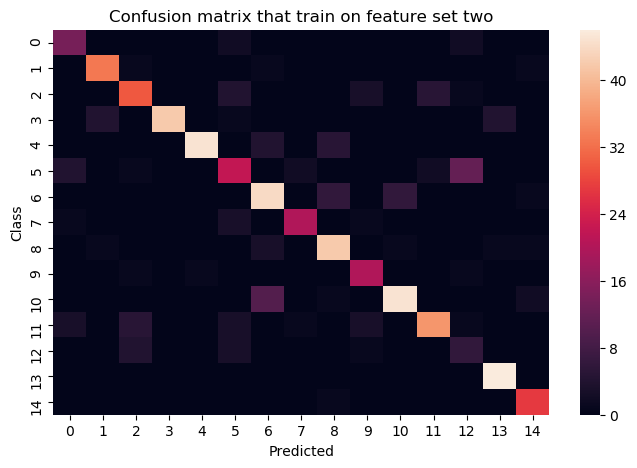

In [45]:
y_pred = resnet_101_b.predict(ft_set_2_strat_test_x)
y_pred = [np.argmax(row) for row in y_pred]
truth = [np.argmax(row) for row in ft_set_2_strat_test_y]
plt.figure(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_pred, truth))
plt.title("Confusion matrix that train on feature set two")
plt.xlabel("Predicted")
plt.ylabel("Class")
plt.show()

** 錯誤預測可能是因為類別中的相似原素 **
<br>類別5與12皆為室內的圖片，類別6與10則都有天空、樹、水..等等戶外景象

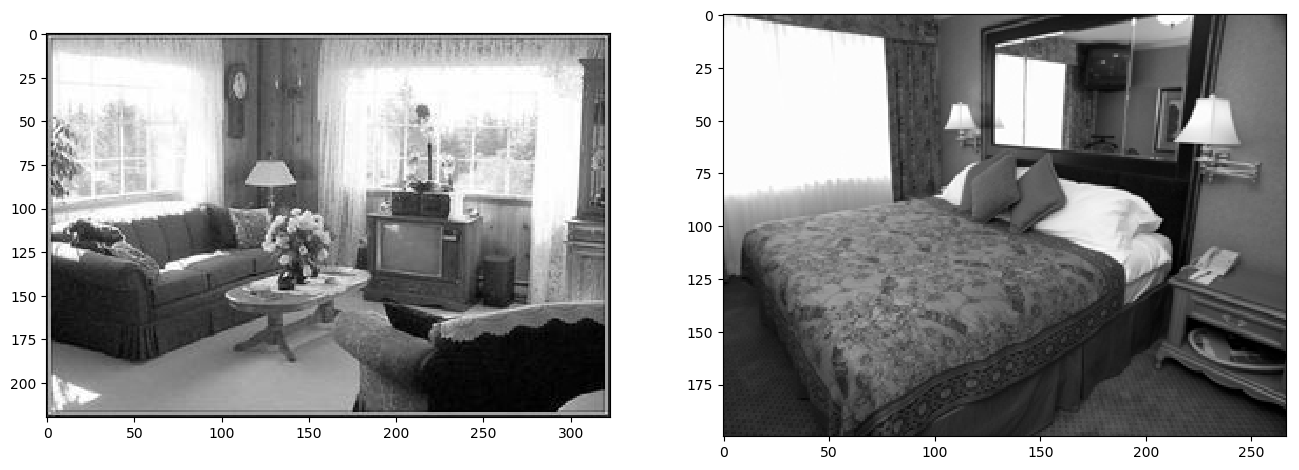

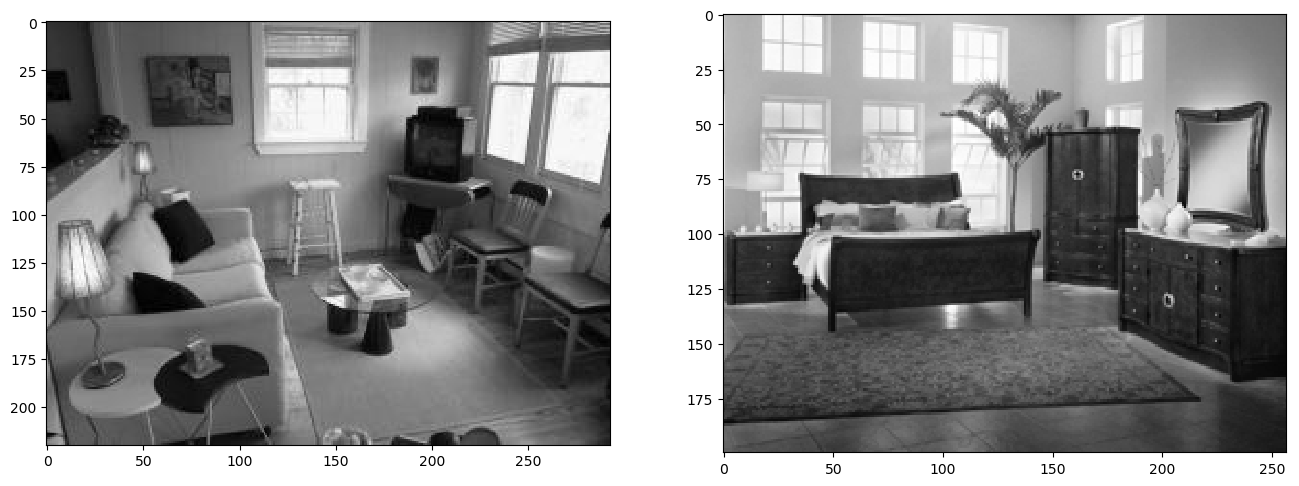

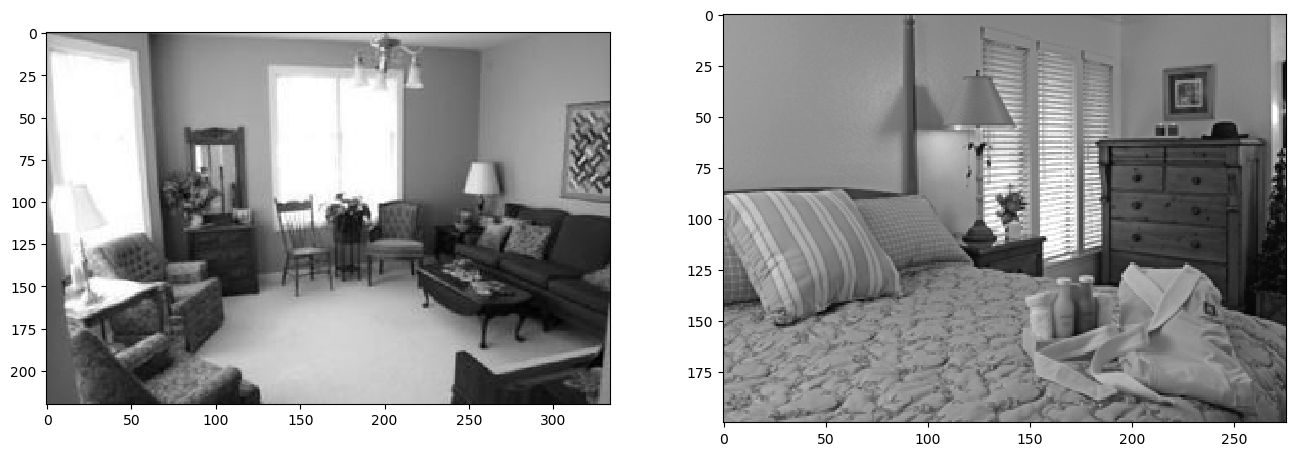

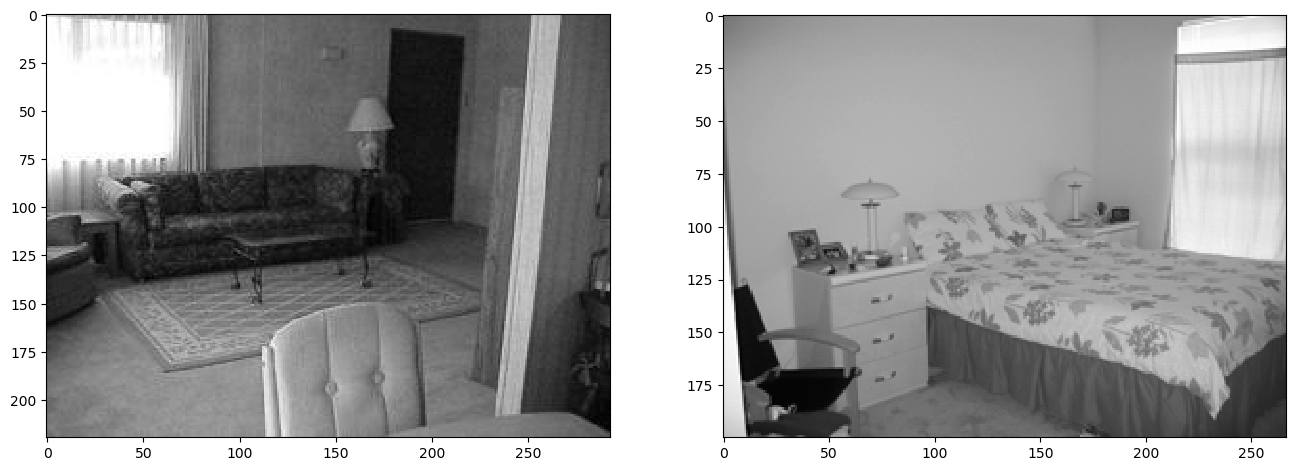

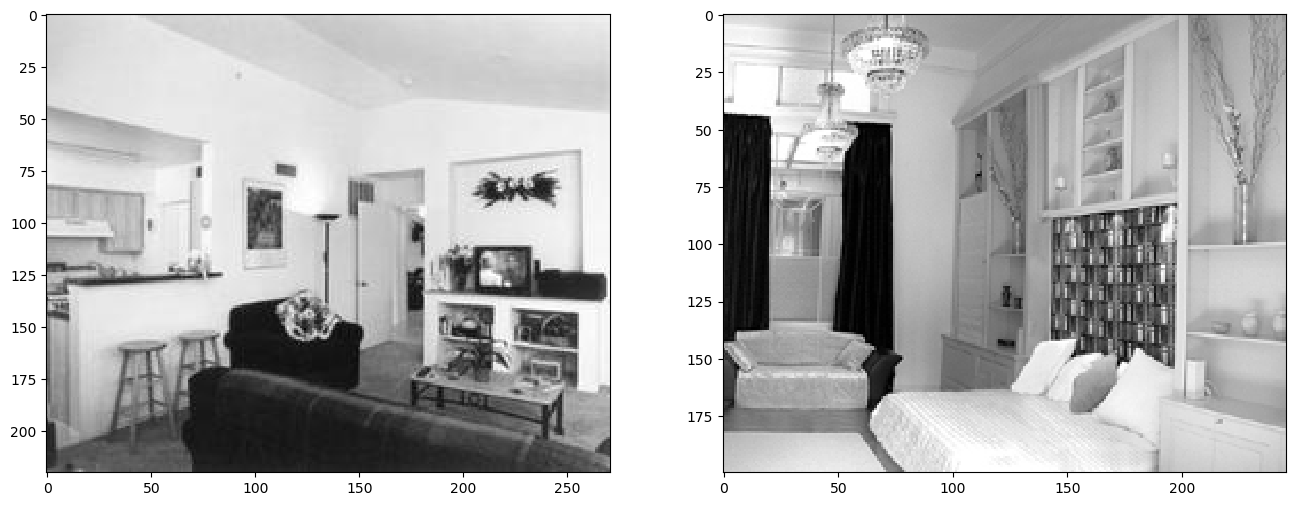

In [55]:
lb_5 = dataset[dataset.int_label == 5]
lb_12 = dataset[dataset.int_label == 12]
for i in range(5):
    fig=plt.gcf()
    fig.set_size_inches(16, 6)
    #Confusion matrix for model trained on feature set one
    plt.subplot(121)
    plt.imshow(cv2.imread(lb_5.iloc[i].img_path))
    plt.subplot(122)
    plt.imshow(cv2.imread(lb_12.iloc[i].img_path))
    plt.show()

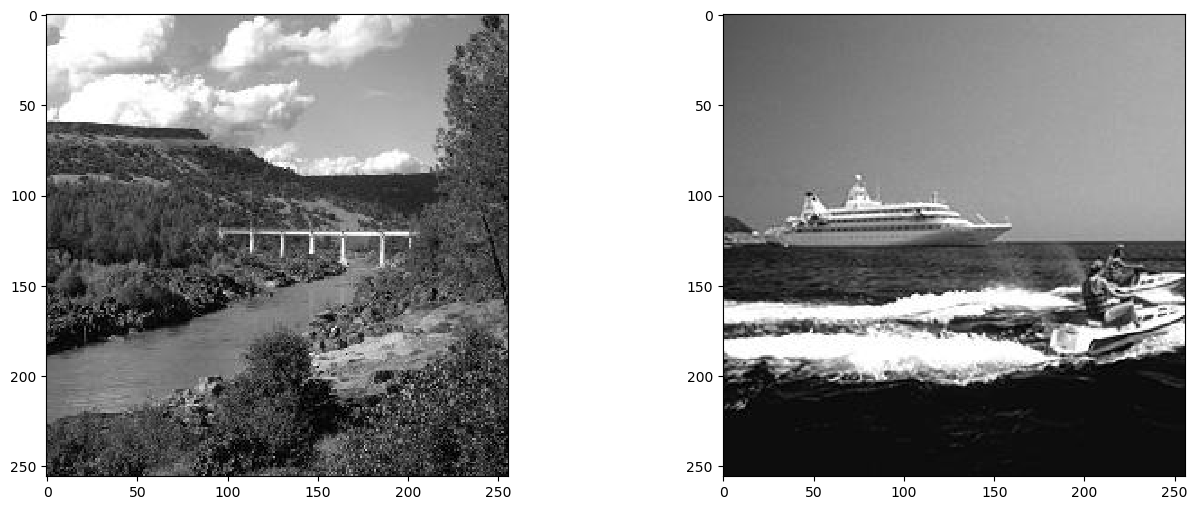

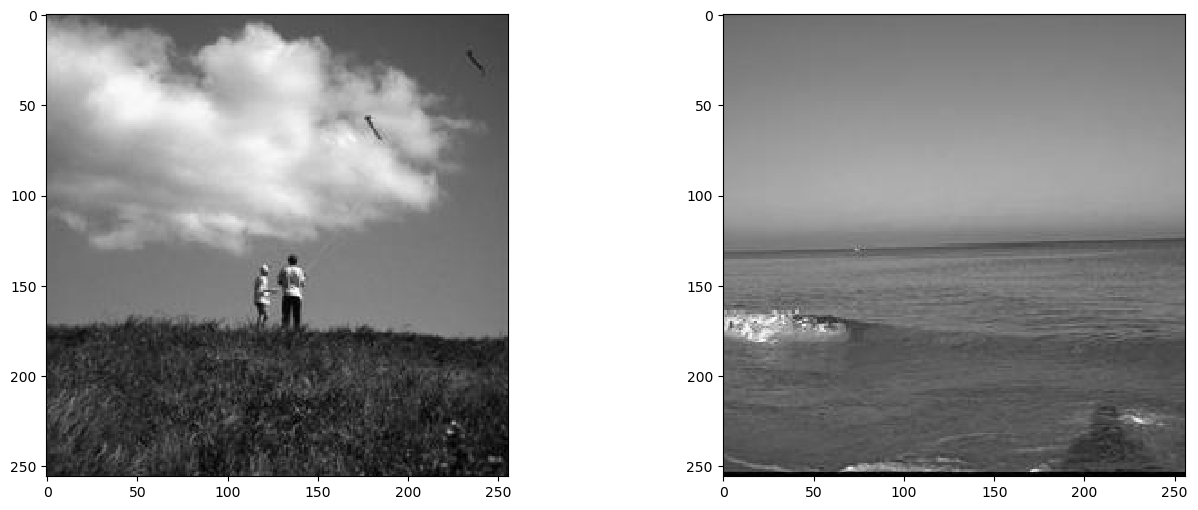

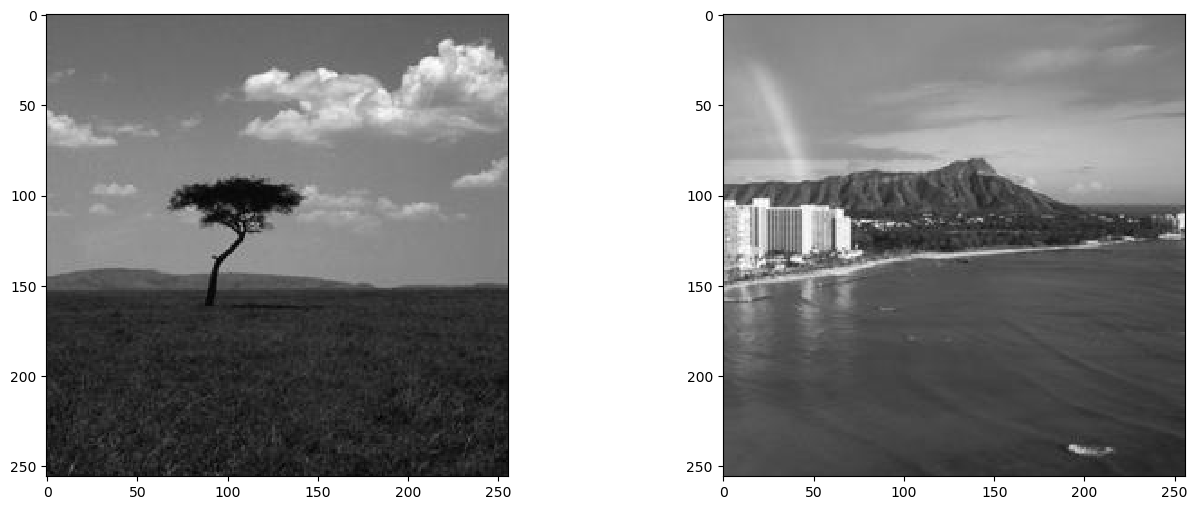

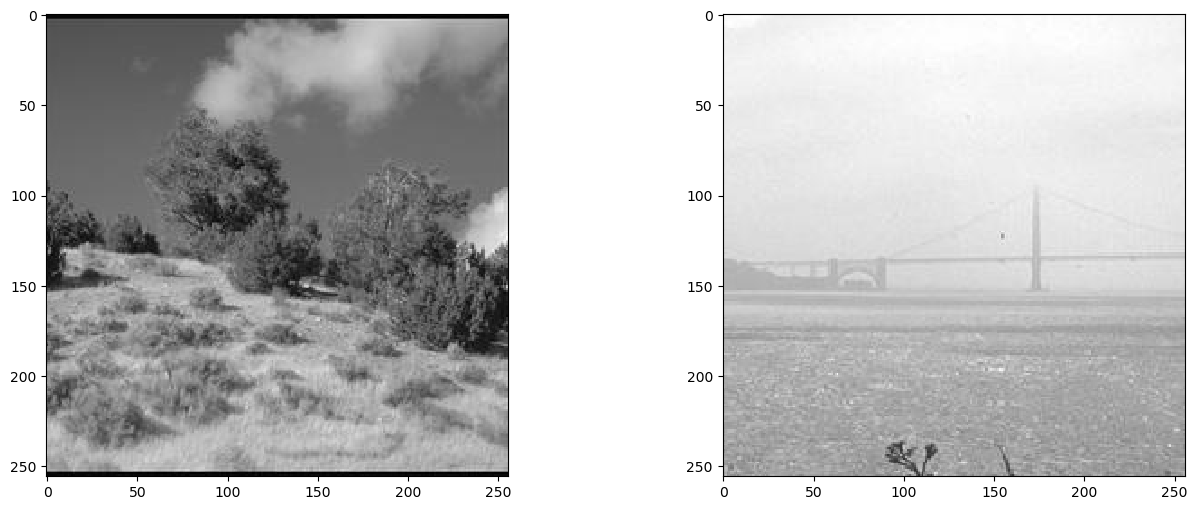

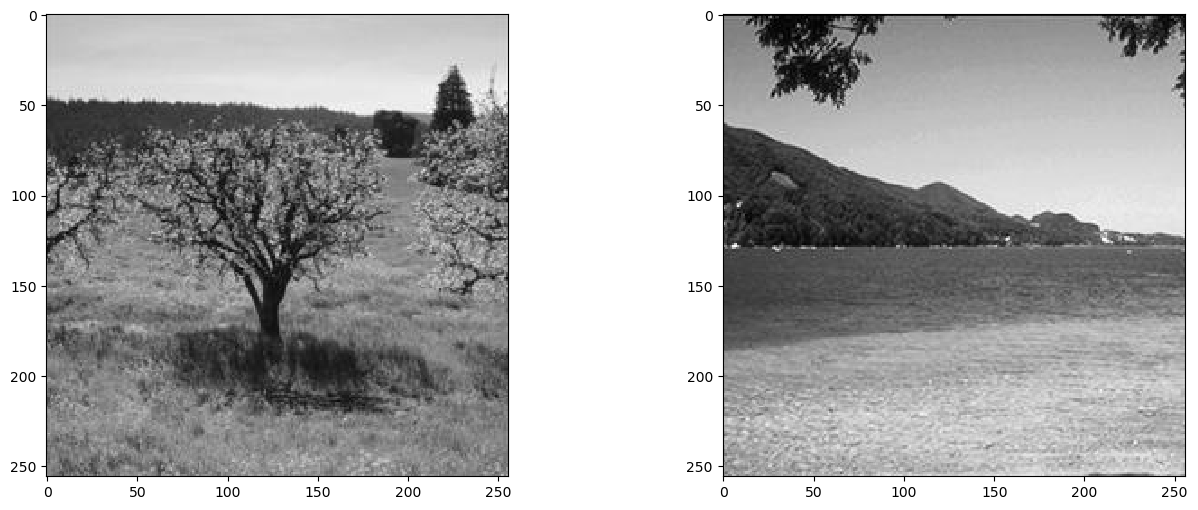

In [56]:
lb_6 = dataset[dataset.int_label == 6]
lb_10 = dataset[dataset.int_label == 10]
for i in range(5):
    fig=plt.gcf()
    fig.set_size_inches(16, 6)
    #Confusion matrix for model trained on feature set one
    plt.subplot(121)
    plt.imshow(cv2.imread(lb_6.iloc[i].img_path))
    plt.subplot(122)
    plt.imshow(cv2.imread(lb_10.iloc[i].img_path))
    plt.show()